In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

import tensorflow as tf
from keras import backend as K
print(tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


1.10.0
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2']


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from keras.utils import to_categorical
from keras.engine import Layer
import keras.layers as layers
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging


logging.basicConfig(level=logging.DEBUG, format='%(name)s - %(levelname)s - %(message)s')

# Initialize session
sess = tf.Session()
K.set_session(sess)

matplotlib.pyplot - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 20190101

def set_random(random_seed):
    seed(random_seed)
    set_random_seed(random_seed)

set_random(RANDOM_SEED)

In [4]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [5]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

logging.debug("train_data.shape: (%d, %d)" % train_data.shape)
logging.debug("valid_data.shape: (%d, %d)" % valid_data.shape)
logging.debug("test_data.shape: (%d, %d)" % test_data.shape)

root - DEBUG - train_data.shape: (4829, 2)
root - DEBUG - valid_data.shape: (537, 2)
root - DEBUG - test_data.shape: (2300, 2)


root - DEBUG - class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
root - DEBUG - class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
root - DEBUG - number of bins: 7
matplotlib.axes._base - DEBUG - update_title_pos
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
matplotlib.axes._base - DEBUG - update_title_pos
matplotlib.axes._base - DEBUG - update_title_pos
matplotlib.axes._base - DEBUG - u

bins: [0, 1, 2, 3, 4, 5, 6, 7]


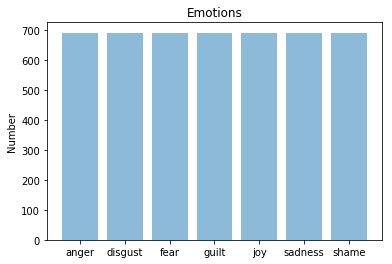

In [6]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
logging.debug("class dictionary: %s" % dic)
logging.debug("class labels: %s" % labels)
logging.debug("number of bins: %s" % n_classes)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]

bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [121]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(valid_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7194 unique tokens.


In [122]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

logging.debug('Shape of X train, validation and test tensor: %s, %s, %s' % (X_train.shape, X_val.shape, X_test.shape))
logging.debug('Shape of label train, validation and test tensor: %s, %s, %s' % (y_train.shape, y_val.shape, y_test.shape))

root - DEBUG - Shape of X train, validation and test tensor: (4829, 192), (537, 192), (2300, 192)
root - DEBUG - Shape of label train, validation and test tensor: (4829, 7), (537, 7), (2300, 7)


In [118]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.sequence_length = 192
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        output = self.elmo(
            inputs={
              "tokens": K.cast(x, tf.string),
              "sequence_len": [192]
            },
            as_dict=True,
            signature='tokens',
        )['default']
        return output

    # def compute_mask(self, inputs, mask=None):
    #     return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.sequence_length, self.dimensions)

In [123]:
from keras.layers.core import Reshape, Flatten
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate
from keras import regularizers


# Function to build model
def build_model(): 
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop_rate = 0.5
  n_class = 7
  EMBEDDING_DIM = 1024
  
  inputs = layers.Input(shape=(sequence_length,), dtype="string")
  embedding = ElmoEmbeddingLayer()(inputs)
  reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

  conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
  conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
  conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
  maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

  merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
  flatten = Flatten()(merged_tensor)
  dropout = Dropout(drop_rate, name='dropout_1')(flatten)
  output = Dense(units=n_class, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  model.summary()
  
  return model

In [124]:
import datetime
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Build and fit
model = build_model()

adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [early_stopping, model_checkpoint]

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


tensorflow - INFO - Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 192)          0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_40 (ElmoEm (None, 192, 1024)    4           input_40[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 192, 1024, 1) 0           elmo_embedding_layer_40[0][0]    
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 190, 1, 100)  307300      reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 (Co

In [125]:
start_time = datetime.datetime.now()

history = model.fit(X_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks)  # starts training

end_time = datetime.datetime.now()

def days_hours_minutes_seconds(td):
  return td.days, td.seconds//3600, (td.seconds//60)%60, (td.seconds%60)

elapsed_time = end_time - start_time
logging.debug("%d days, %d hours, %d minutes, %d seconds elapsed" % (days_hours_minutes_seconds(elapsed_time)))

Train on 4829 samples, validate on 537 samples
Epoch 1/100


InternalError: Unable to get element as bytes.

In [ ]:
model.save('isear_dense_elmo_model.h5')
model.save_weights('isear_dense_elmo_weights.h5')

logging.debug("model and weights is successfully saved")

## Evaluate the model

In [ ]:
y_pred = model.predict(X_test)

y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

In [ ]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [ ]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

### Performance score for each classes

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

### Performance score using micro average

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

### Performance score using macro average

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

### Performance score using weighted average

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

### Cohen Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)